## Entrenamiento de un modelo XGBoost

In [2]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

airline_df = pd.read_csv('../Data/airline_recoded.csv')

X = airline_df.drop(columns = ['satisfaction'])
y = airline_df['satisfaction']

Entrenamiento del modelo

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBClassifier(eval_metric="logloss")

model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

results = model.evals_result()

y_pred = model.predict(X_test)

cv_scores = cross_val_score(model, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

Puntajes de validación cruzada: [0.96140705 0.96333189 0.96039652 0.96376498 0.96270452]
Media de los puntajes: 0.962320992296074


Evaluación del modelo con matriz de confusión

Precisión del modelo: 0.9613114333376107


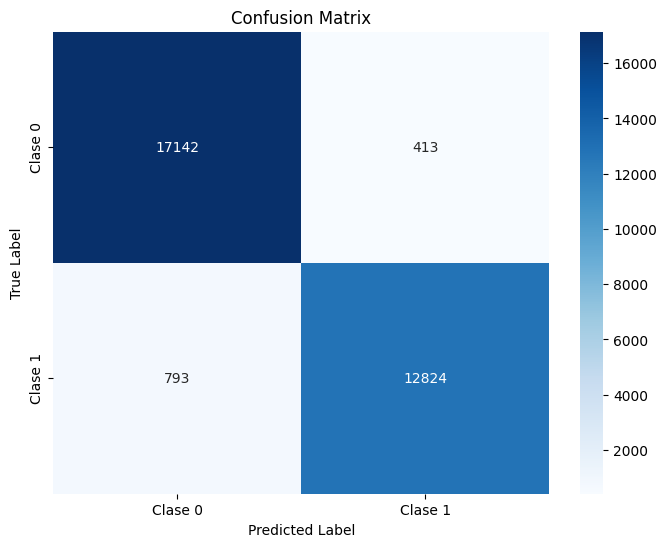

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17555
           1       0.97      0.94      0.96     13617

    accuracy                           0.96     31172
   macro avg       0.96      0.96      0.96     31172
weighted avg       0.96      0.96      0.96     31172



In [4]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy}")
plt.show()
print("Reporte de clasificación:\n", class_report)

Cálculo de curva ROC para evaluación de rendimiento del modelo

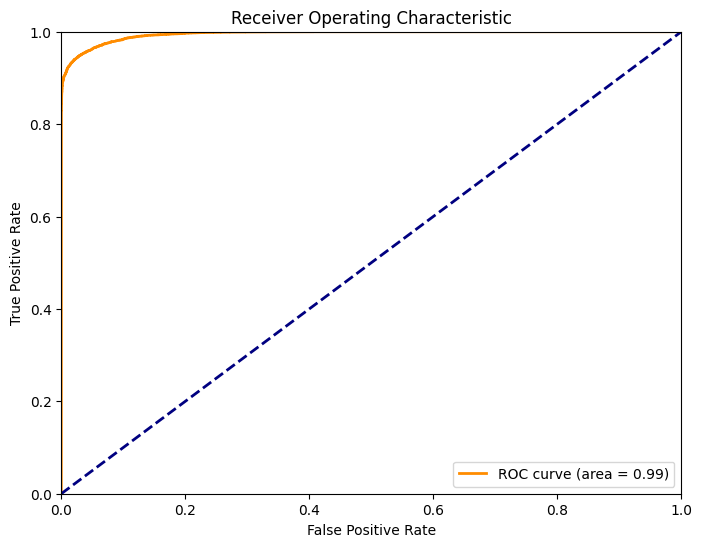

In [5]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Visualización de overfitting

Training Accuracy: 0.9777951933124347
Test Accuracy: 0.9613114333376107


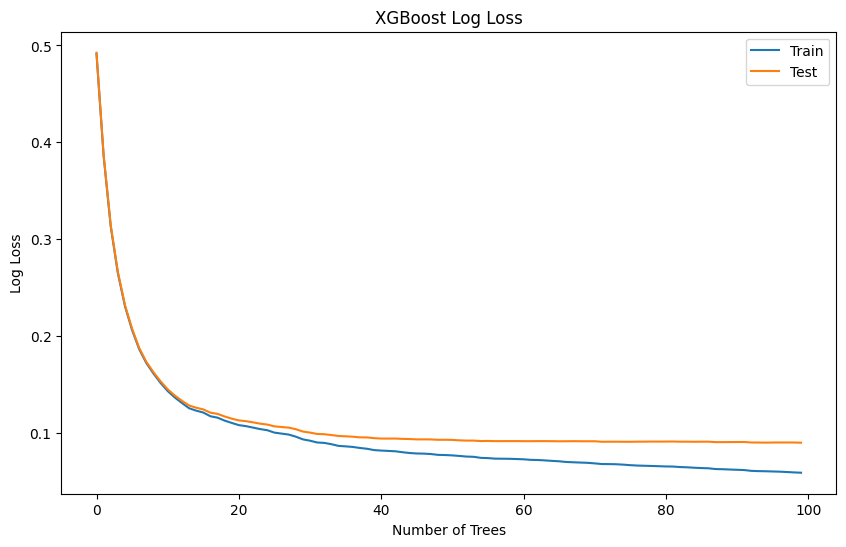

El modelo parece tener un buen ajuste.


In [6]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend(loc='upper right')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

if train_accuracy > test_accuracy + 0.05:  # Fijamos un 5% que es lo solicitado en el briefing
    print("El modelo podría estar sobreajustado (overfitting).")
else:
    print("El modelo parece tener un buen ajuste.")

### Pruebas con nuevos datos

Generamos una base de datos aleatoria

In [7]:
import random

def generar_valores_aleatorios():
    return {
        'Gender': random.randint(0, 1),
        'Customer Type': random.randint(0, 1),
        'Age': random.randint(0, 100),
        'Type of Travel': random.randint(0, 1),
        'Class': random.randint(0, 2),
        'Flight Distance': random.randint(0, 10000),
        'Inflight wifi service': random.randint(0, 6),
        'Departure/Arrival time convenient': random.randint(0, 6),
        'Ease of Online booking': random.randint(0, 6),
        'Gate location': random.randint(0, 6),
        'Food and drink': random.randint(0, 6),
        'Online boarding': random.randint(0, 6),
        'Seat comfort': random.randint(0, 6),
        'Inflight entertainment': random.randint(0, 6),
        'On-board service': random.randint(0, 6),
        'Leg room service': random.randint(0, 6),
        'Baggage handling': random.randint(0, 6),
        'Checkin service': random.randint(0, 6),
        'Inflight service': random.randint(0, 6),
        'Cleanliness': random.randint(0, 6),
        'Departure Delay in Minutes': random.randint(0, 2000),
        'Arrival Delay in Minutes': random.randint(0, 2000)
    }

# Base de datos
num_filas = 10000
datos = [generar_valores_aleatorios() for _ in range(num_filas)]

df = pd.DataFrame(datos)

print(df.head())

   Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       1              1   30               1      0             8660   
1       1              0   74               1      1             5954   
2       1              1    9               1      0             1303   
3       0              0   43               0      0             3226   
4       1              0   40               0      2              664   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      2                                  3   
1                      6                                  5   
2                      3                                  3   
3                      0                                  1   
4                      0                                  3   

   Ease of Online booking  Gate location  ...  Seat comfort  \
0                       0              1  ...             4   
1                       1              6  ...           

In [8]:
import numpy as np

prediccion = model.predict(df)
predicted_probability = model.predict_proba(df)[:, 1]

df['Prediccion'] = prediccion
df['Predicted_Probability'] = np.round(predicted_probability, 2)

print(df.head())
df.to_csv('../Data/XGBoost_predicciones.csv', index=False)

   Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       1              1   30               1      0             8660   
1       1              0   74               1      1             5954   
2       1              1    9               1      0             1303   
3       0              0   43               0      0             3226   
4       1              0   40               0      2              664   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      2                                  3   
1                      6                                  5   
2                      3                                  3   
3                      0                                  1   
4                      0                                  3   

   Ease of Online booking  Gate location  ...  On-board service  \
0                       0              1  ...                 6   
1                       1              6  ...   

Selección de Hyperparametros con hyperopt

In [9]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf = xgb.XGBClassifier(
        n_estimators=space['n_estimators'],
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],  # float entre 0 y 1
        eval_metric='logloss'  # Desde el constructor
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.9446618760426023                                     
SCORE:                                                                            
0.9421596304375722                                                                
SCORE:                                                                            
0.9438598742461183                                                                
SCORE:                                                                            
0.9439881945335558                                                                
SCORE:                                                                            
0.9443410753240087                                                                
SCORE:                                                                            
0.9482227640189914                                                                
SCORE:                                                    

Puntajes de validación cruzada: [0.95972282 0.96010779 0.95784611 0.96116645 0.96116458]
Media de los puntajes: 0.9600015510762845
Precisión del modelo: 0.9601565507506736


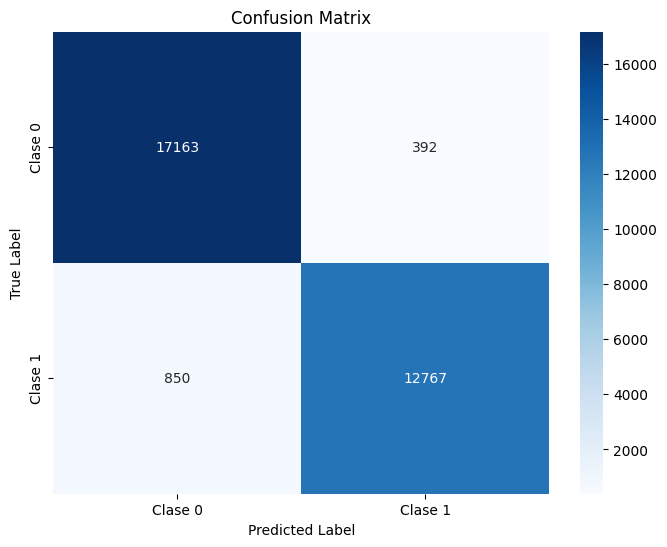

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     17555
           1       0.97      0.94      0.95     13617

    accuracy                           0.96     31172
   macro avg       0.96      0.96      0.96     31172
weighted avg       0.96      0.96      0.96     31172



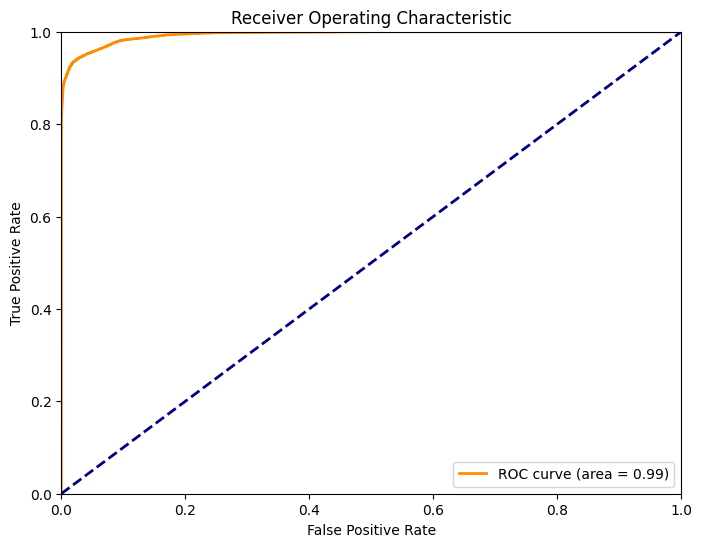

Training Accuracy: 0.9614062585931914
Test Accuracy: 0.9601565507506736


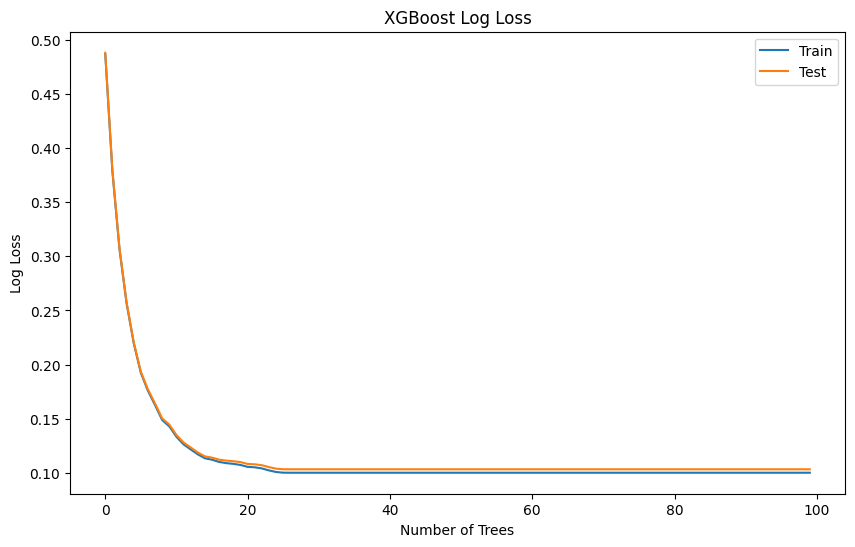

El modelo parece tener un buen ajuste.


In [10]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

airline_df = pd.read_csv('../Data/airline_recoded.csv')

X = airline_df.drop(columns = ['satisfaction'])
y = airline_df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBClassifier(
    max_depth=int(best_hyperparams['max_depth']),
    gamma=best_hyperparams['gamma'],
    reg_alpha=int(best_hyperparams['reg_alpha']),
    min_child_weight=int(best_hyperparams['min_child_weight']),
    colsample_bytree=best_hyperparams['colsample_bytree'],
    eval_metric='logloss'  
)

model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

results = model.evals_result()

y_pred = model.predict(X_test)

cv_scores = cross_val_score(model, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

train_accuracy = model.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend(loc='upper right')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

if train_accuracy > test_accuracy + 0.05:  # Fijamos un 5% que es lo solicitado en el briefing
    print("El modelo podría estar sobreajustado (overfitting).")
else:
    print("El modelo parece tener un buen ajuste.")

### Modelo urilizando ensemble

Precisión del modelo stacking: 0.9596111895290645
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     17555
           1       0.97      0.94      0.95     13617

    accuracy                           0.96     31172
   macro avg       0.96      0.96      0.96     31172
weighted avg       0.96      0.96      0.96     31172



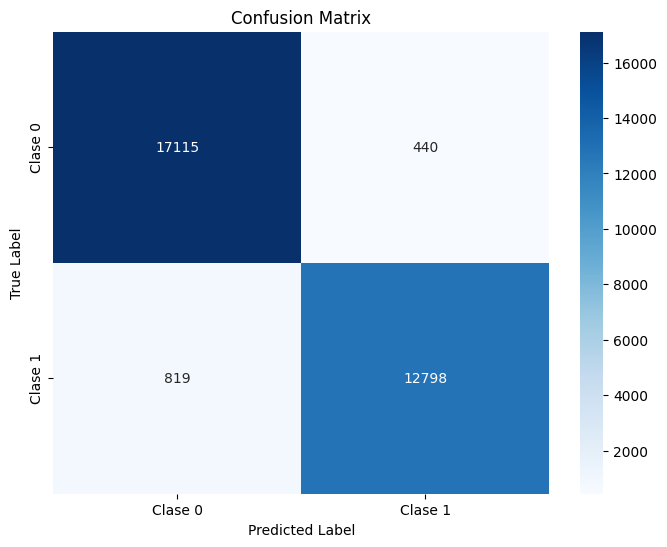

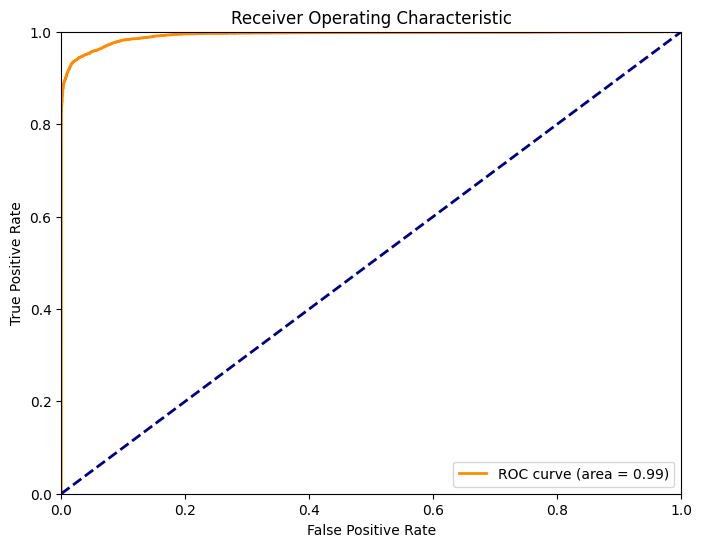

Training Accuracy: 0.9621212121212122
Test Accuracy: 0.9596111895290645
El modelo parece tener un buen ajuste.
Puntajes de validación cruzada: [0.95991531 0.96030027 0.95799047 0.96159954 0.96102021]
Media de los puntajes: 0.9601651606776549


In [11]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

airline_df = pd.read_csv('../Data/airline_recoded.csv')

X = airline_df.drop(columns = ['satisfaction'])
y = airline_df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(
    max_depth=int(best_hyperparams['max_depth']),
    gamma=best_hyperparams['gamma'],
    reg_alpha=int(best_hyperparams['reg_alpha']),
    min_child_weight=int(best_hyperparams['min_child_weight']),
    colsample_bytree=best_hyperparams['colsample_bytree'],
    eval_metric='logloss'
)

rf_model = RandomForestClassifier(
    n_estimators=100,  # Número de árboles en el bosque
    max_depth=10,      # Profundidad máxima del árbol
    random_state=42
)

log_reg_model = LogisticRegression(
    random_state=42,
    max_iter=200,
    solver='liblinear'
)


stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('log_reg', log_reg_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5  # Realizar validación cruzada
)

stacking_model.fit(X_train, y_train)

# Realizar predicciones con el conjunto de prueba
y_pred = stacking_model.predict(X_test)

# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Precisión del modelo stacking: {accuracy}")
print("Reporte de clasificación:\n", class_report)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Probabilidades de predicción
y_prob = stacking_model.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

train_accuracy = stacking_model.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Comprobar si hay sobreajuste
if train_accuracy > test_accuracy + 0.05:
    print("El modelo podría estar sobreajustado (overfitting).")
else:
    print("El modelo parece tener un buen ajuste.")

cv_scores = cross_val_score(stacking_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

In [12]:
from sklearn.model_selection import StratifiedKFold

train_accuracies = []
test_accuracies = []

cv = 5  # Definir número de folds
for train_idx, test_idx in StratifiedKFold(n_splits=cv).split(X, y):
    # Dividir datos en folds de entrenamiento y prueba
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el ensemble en el fold
    stacking_model.fit(X_train_fold, y_train_fold)

    # Guardar precisión en el conjunto de entrenamiento y prueba
    train_acc = stacking_model.score(X_train_fold, y_train_fold)
    test_acc = stacking_model.score(X_test_fold, y_test_fold)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)



Train accuracies: [0.9625133837806624, 0.9621645032060921, 0.9622005943000133, 0.9627660214381097, 0.9611905105625331]
Test accuracies: [0.9599153072518166, 0.960300274289014, 0.9579904720658293, 0.9615995380395553, 0.9610202117420596]


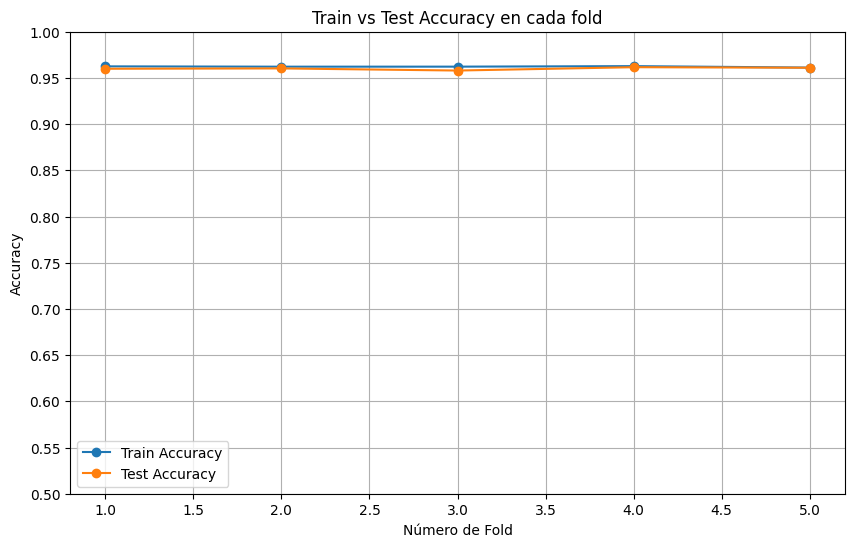

In [14]:
print(f"Train accuracies: {train_accuracies}")
print(f"Test accuracies: {test_accuracies}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, cv+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, cv+1), test_accuracies, label='Test Accuracy', marker='o')

plt.ylim(0.5, 1)
plt.yticks(np.arange(0.50, 1.05, 0.05))

plt.title('Train vs Test Accuracy en cada fold')
plt.xlabel('Número de Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()